<a href="https://colab.research.google.com/github/Toneejake/studybuddy-prototype/blob/main/training_berong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install All Required Packages

print("Installing dependencies for SafeScape v2.0-Full (Resume)...")

# Core ML libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Standard ML tools
!pip install datasets Pillow matplotlib scikit-learn -q

# Gymnasium (compatible with SB3)
!pip install gymnasium==0.29.1 -q

# Stable Baselines3 + Contrib (for MaskablePPO)
!pip install stable-baselines3==2.2.1 -q
!pip install sb3-contrib==2.2.1 -q

# Utilities
!pip install opencv-python-headless tqdm -q

print("✅ All dependencies installed successfully!")
print("\nGPU Status:")
!nvidia-smi --query-gpu=name,memory.total --format=csv

Installing dependencies for SafeScape v2.0-Full (Resume)...
✅ All dependencies installed successfully!

GPU Status:
name, memory.total [MiB]
Tesla T4, 15360 MiB


In [ ]:
# Cell 2: Import Libraries and Configuration

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import heapq
import cv2
from tqdm import tqdm
import os
import random
import pickle
import time

# Gymnasium and RL libraries
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker

# Configuration
config = {
    "image_size": 256,
    "max_agents": 10,
    "max_exits": 248,
    "fire_spread_prob": 0.25,
    "firewall_spread_factor": 0.1,
    "max_steps_per_episode": 500,

    # Resume configuration
    "resume_checkpoint": "ppo_v2_full_200096_steps.zip",  # Will upload this
    "target_timesteps": 500000,  # Final target
    "checkpoint_dir": "./checkpoints_v2_full_resume/",
}

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {device}")
print(f"🎯 Target: 500,000 timesteps")

🖥️  Device: cuda
🎯 Target: 500,000 timesteps


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Cell 3: Upload Required Files

print("="*60)
print("📤 UPLOAD REQUIRED FILES")
print("="*60)

required_files = {
    'ppo_v2_full_200096_steps.zip': 'Latest checkpoint (~200k steps)',
    'processed_floor_plans_1000.pkl': 'Pre-processed floor plans',
    'unet_floorplan_model.pth': 'U-Net perception model'
}

print("\nPlease upload these files using the file browser (left sidebar):\n")
for file, desc in required_files.items():
    print(f"  📄 {file}")
    print(f"     ({desc})\n")

print("After uploading all files, re-run this cell to verify.\n")
print("="*60)

# Verification
all_present = True
for file, desc in required_files.items():
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / 1024 / 1024
        print(f"✅ {file} ({size_mb:.1f} MB)")
    else:
        print(f"❌ {file} - NOT FOUND")
        all_present = False

if all_present:
    print("\n🎉 All files uploaded successfully!")
    print("✅ Ready to proceed to next cell")
else:
    print("\n⚠️  Please upload missing files and re-run this cell")

📤 UPLOAD REQUIRED FILES

Please upload these files using the file browser (left sidebar):

  📄 ppo_v2_full_200096_steps.zip
     (Latest checkpoint (~200k steps))

  📄 processed_floor_plans_1000.pkl
     (Pre-processed floor plans)

  📄 unet_floorplan_model.pth
     (U-Net perception model)

After uploading all files, re-run this cell to verify.

✅ ppo_v2_full_200096_steps.zip (6.5 MB)
✅ processed_floor_plans_1000.pkl (250.0 MB)
✅ unet_floorplan_model.pth (29.7 MB)

🎉 All files uploaded successfully!
✅ Ready to proceed to next cell


In [ ]:
# Cell 4: A*, FireSimulator, Person Agent

# ============================================
# A* PATHFINDING
# ============================================
def a_star_search(grid, start, goal, fire_map=None):
    """A* pathfinding with fire avoidance."""
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    close_set = set()
    came_from = {}
    gscore = {start: 0}
    fscore = {start: heuristic(start, goal)}
    oheap = []
    heapq.heappush(oheap, (fscore[start], start))

    while oheap:
        current = heapq.heappop(oheap)[1]

        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        close_set.add(current)

        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j
            tentative_g_score = gscore[current] + 1

            if 0 <= neighbor[0] < grid.shape[1] and 0 <= neighbor[1] < grid.shape[0]:
                if grid[neighbor[1]][neighbor[0]] == 1:
                    continue
                if fire_map is not None and fire_map[neighbor[1]][neighbor[0]] == 1:
                    continue
            else:
                continue

            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue

            if tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1] for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(oheap, (fscore[neighbor], neighbor))

    return []

# ============================================
# FIRE SIMULATOR
# ============================================
class FireSimulator:
    def __init__(self, grid, spread_probability=0.25, firewall_spread_factor=0.1):
        self.base_grid = grid
        self.spread_probability = spread_probability
        self.firewall_spread_factor = firewall_spread_factor
        self.fire_map = np.zeros_like(self.base_grid, dtype=float)
        self.directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def start_fire(self, ignition_points):
        for y, x in ignition_points:
            if 0 <= y < self.fire_map.shape[0] and 0 <= x < self.fire_map.shape[1]:
                self.fire_map[y, x] = 1

    def step(self):
        new_fire_map = self.fire_map.copy()
        rows, cols = self.fire_map.shape
        burning_cells = np.argwhere(self.fire_map == 1)

        for r, c in burning_cells:
            for dr, dc in self.directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    if self.fire_map[nr, nc] == 0:
                        neighbor_type = self.base_grid[nr, nc]
                        current_spread_prob = self.spread_probability
                        if neighbor_type == 1:
                            current_spread_prob = 0
                        elif neighbor_type == 2:
                            current_spread_prob *= self.firewall_spread_factor
                        if np.random.rand() < current_spread_prob:
                            new_fire_map[nr, nc] = 1

        self.fire_map = new_fire_map

    def reset(self, ignition_points=None):
        self.fire_map = np.zeros_like(self.base_grid, dtype=float)
        if ignition_points:
            self.start_fire(ignition_points)

# ============================================
# PERSON AGENT
# ============================================
class Person:
    def __init__(self, position):
        self.initial_pos = tuple(position)
        self.pos = list(position)
        self.path = []
        self.status = 'evacuating'
        self.state = 'CALM'
        self.speed = 1.0
        self.trip_probability = 0.0
        self.tripped_timer = 0
        self.PANIC_DISTANCE = 25
        self.ALERT_DISTANCE = 50

    def update_state(self, fire_map):
        if self.tripped_timer > 0:
            return
        fire_locations = np.argwhere(fire_map == 1)
        if len(fire_locations) == 0:
            min_dist = float('inf')
        else:
            agent_pos_yx = np.array([self.pos[1], self.pos[0]])
            min_dist = np.min(np.linalg.norm(fire_locations - agent_pos_yx, axis=1))
        if min_dist < self.PANIC_DISTANCE:
            self.state = 'PANICKED'
            self.speed = 1.5
            self.trip_probability = 0.1
        elif min_dist < self.ALERT_DISTANCE:
            self.state = 'ALERT'
            self.speed = 1.2
            self.trip_probability = 0.0
        else:
            self.state = 'CALM'
            self.speed = 1.0
            self.trip_probability = 0.0

    def move(self):
        if self.tripped_timer > 0:
            self.tripped_timer -= 1
            return
        if self.state == 'PANICKED':
            if np.random.rand() < self.trip_probability:
                self.tripped_timer = 5
                return
        steps_to_move = int(round(self.speed))
        for _ in range(steps_to_move):
            if self.path:
                self.pos = list(self.path.pop(0))
            else:
                break

    def check_status(self, fire_map, exits):
        if self.status != 'evacuating':
            return
        pos_int = (int(self.pos[1]), int(self.pos[0]))
        if fire_map[pos_int[0], pos_int[1]] == 1:
            self.status = 'burned'
            return
        for ex in exits:
            if np.linalg.norm(np.array(self.pos) - np.array(ex)) < 5:
                self.status = 'escaped'
                return

    def compute_path(self, grid, goal, fire_map):
        start_pos = (int(self.pos[0]), int(self.pos[1]))
        goal_pos = (int(goal[0]), int(goal[1]))
        self.path = a_star_search(grid, start_pos, goal_pos, fire_map)

    def reset(self):
        self.pos = list(self.initial_pos)
        self.path = []
        self.status = 'evacuating'
        self.state = 'CALM'
        self.speed = 1.0
        self.trip_probability = 0.0
        self.tripped_timer = 0

print("✅ Core simulation classes defined")

✅ Core simulation classes defined


In [ ]:
# Cell 5: EvacuationEnvV2 (Same as before)

class EvacuationEnvV2(gym.Env):
    """V2.0: Fixed observation/action spaces with masking."""

    def __init__(self, grid, num_agents=5, max_steps=500,
                 agent_start_positions=None, fire_start_position=None, exits=None):
        super(EvacuationEnvV2, self).__init__()
        self.base_grid = grid
        self.num_agents = num_agents
        self.max_steps = max_steps
        self.initial_agent_positions = agent_start_positions
        self.initial_fire_position = fire_start_position
        self.initial_exits = exits
        self.MAX_EXITS = config['max_exits']
        self.action_space = spaces.Discrete(self.MAX_EXITS)
        self.MAX_AGENTS = config['max_agents']
        fire_obs_shape = 64 * 64
        agent_pos_shape = self.MAX_AGENTS * 2
        agent_state_shape = self.MAX_AGENTS * 1
        obs_shape = fire_obs_shape + agent_pos_shape + agent_state_shape + 1
        self.observation_space = spaces.Box(low=0, high=1, shape=(obs_shape,), dtype=np.float32)
        self.all_possible_exit_slots = self._generate_exit_slots()
        self.exits = self._find_exits() if self.initial_exits is None else self.initial_exits
        if not self.exits:
            raise ValueError("No exits found or provided.")
        self.valid_exit_indices = self._map_exits_to_slots()
        self.fire_sim = FireSimulator(self.base_grid)
        self.agents = []

    def _generate_exit_slots(self):
        size = self.base_grid.shape[0]
        slots = []
        for x in range(1, size-1):
            slots.append((x, 1))
        for x in range(1, size-1):
            slots.append((x, size-2))
        for y in range(1, size-1):
            slots.append((1, y))
        for y in range(1, size-1):
            slots.append((size-2, y))
        return slots[:self.MAX_EXITS]

    def _find_exits(self):
        rows, cols = self.base_grid.shape
        exits = []
        for x in range(cols):
            if self.base_grid[1, x] == 0:
                exits.append((x, 1))
            if self.base_grid[rows-2, x] == 0:
                exits.append((x, rows-2))
        for y in range(rows):
            if self.base_grid[y, 1] == 0:
                exits.append((1, y))
            if self.base_grid[y, cols-2] == 0:
                exits.append((cols-2, y))
        if not exits:
            return []
        filtered_exits = [exits[0]]
        for ex in exits:
            if all(np.linalg.norm(np.array(ex) - np.array(f_ex)) > 20 for f_ex in filtered_exits):
                filtered_exits.append(ex)
        return filtered_exits

    def _map_exits_to_slots(self):
        indices = []
        for exit_pos in self.exits:
            distances = [np.linalg.norm(np.array(exit_pos) - np.array(slot))
                        for slot in self.all_possible_exit_slots]
            nearest_idx = np.argmin(distances)
            indices.append(nearest_idx)
        return indices

    def action_masks(self):
        mask = np.zeros(self.MAX_EXITS, dtype=bool)
        mask[self.valid_exit_indices] = True
        return mask

    def _get_observation(self):
        fire_map_resized = cv2.resize(self.fire_sim.fire_map.astype(np.float32),
                                     (64, 64), interpolation=cv2.INTER_AREA)
        fire_obs = fire_map_resized.flatten()
        agent_positions = np.zeros(self.MAX_AGENTS * 2, dtype=np.float32)
        for i, agent in enumerate(self.agents[:self.MAX_AGENTS]):
            agent_positions[i*2] = agent.pos[0] / self.base_grid.shape[1]
            agent_positions[i*2 + 1] = agent.pos[1] / self.base_grid.shape[0]
        state_map = {'CALM': 0.0, 'ALERT': 0.5, 'PANICKED': 1.0}
        agent_states = np.zeros(self.MAX_AGENTS, dtype=np.float32)
        for i, agent in enumerate(self.agents[:self.MAX_AGENTS]):
            agent_states[i] = state_map.get(agent.state, 0.0)
        time_obs = np.array([self.current_step / self.max_steps])
        return np.concatenate([fire_obs, agent_positions, agent_states, time_obs]).astype(np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        fire_start = self.initial_fire_position or (self.base_grid.shape[0] // 2, self.base_grid.shape[1] // 2)
        self.fire_sim.reset(ignition_points=[fire_start])
        self.agents = []
        if self.initial_agent_positions:
            for pos in self.initial_agent_positions[:self.num_agents]:
                self.agents.append(Person(position=pos))
        else:
            max_attempts = 1000
            attempts = 0
            while len(self.agents) < self.num_agents and attempts < max_attempts:
                attempts += 1
                y = np.random.randint(10, self.base_grid.shape[0]-10)
                x = np.random.randint(10, self.base_grid.shape[1]-10)
                if self.base_grid[y, x] == 0 and self.fire_sim.fire_map[y, x] == 0:
                    too_close = False
                    for existing_agent in self.agents:
                        if np.linalg.norm(np.array([x, y]) - np.array(existing_agent.pos)) < 10:
                            too_close = True
                            break
                    if not too_close:
                        self.agents.append(Person(position=(x, y)))
            if len(self.agents) < self.num_agents:
                self.num_agents = len(self.agents)
            if len(self.agents) == 0:
                center_y, center_x = self.base_grid.shape[0] // 2, self.base_grid.shape[1] // 2
                self.agents.append(Person(position=(center_x, center_y)))
        for agent in self.agents:
            agent.reset()
        return self._get_observation(), {}

    def step(self, action):
        self.current_step += 1
        self.fire_sim.step()
        if action in self.valid_exit_indices:
            target_exit = self.exits[self.valid_exit_indices.index(action)]
        else:
            target_exit = self.exits[0]
        reward = -0.01
        for agent in self.agents:
            if agent.status == 'evacuating':
                agent.update_state(self.fire_sim.fire_map)
                if agent.state != 'PANICKED' and (not agent.path or self.current_step % 10 == 0):
                    agent.compute_path(self.base_grid, target_exit, self.fire_sim.fire_map)
                agent.move()
                agent.check_status(self.fire_sim.fire_map, self.exits)
                if agent.status == 'escaped':
                    reward += 10
                elif agent.status == 'burned':
                    reward -= 10
        terminated = all(agent.status != 'evacuating' for agent in self.agents)
        truncated = self.current_step >= self.max_steps
        return self._get_observation(), reward, terminated, truncated, {}

print("✅ Environment V2.0 defined")

✅ Environment V2.0 defined


📦 LOADING PROCESSED FLOOR PLANS
✅ Loaded 1000 floor plan layouts


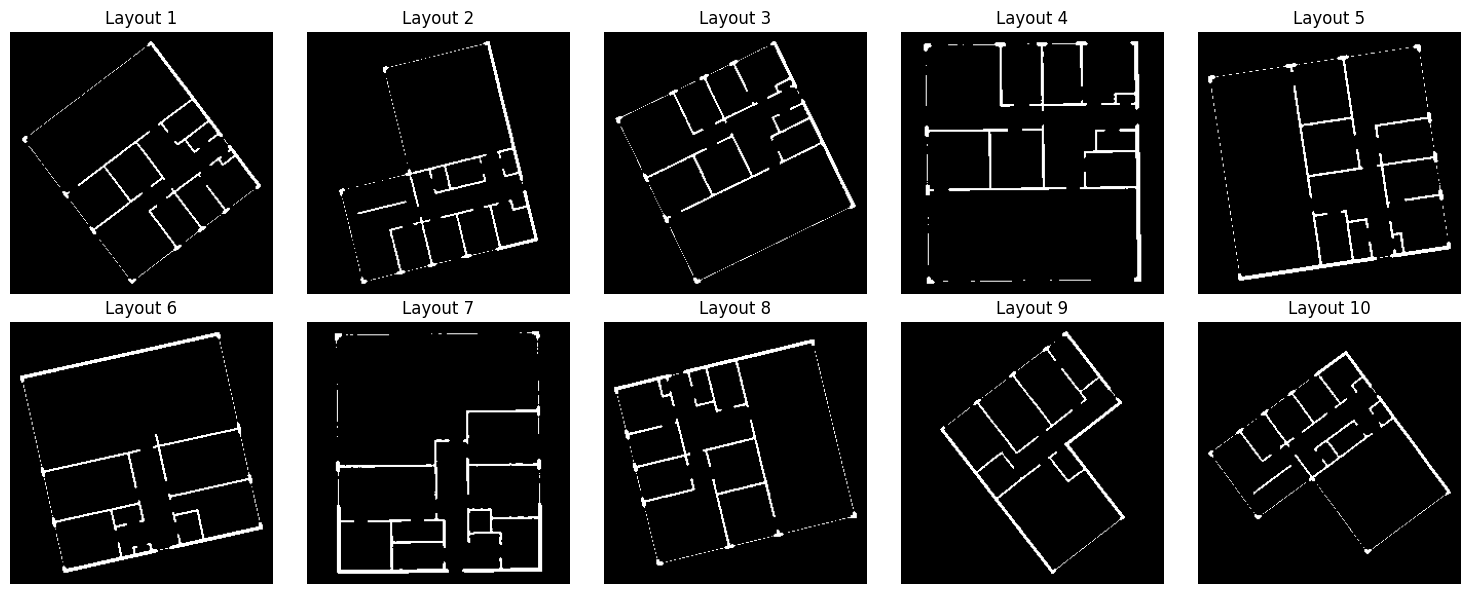


🎯 Ready to resume training on 1000 layouts!


In [ ]:
# Cell 6: Load Pre-processed Floor Plans

print("="*60)
print("📦 LOADING PROCESSED FLOOR PLANS")
print("="*60)

with open('processed_floor_plans_1000.pkl', 'rb') as f:
    processed_grids = pickle.load(f)

print(f"✅ Loaded {len(processed_grids)} floor plan layouts")

# Quick visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < len(processed_grids):
        ax.imshow(processed_grids[i], cmap='gray')
        ax.set_title(f"Layout {i+1}")
        ax.axis('off')
plt.tight_layout()
plt.show()

print(f"\n🎯 Ready to resume training on {len(processed_grids)} layouts!")

In [ ]:
# Cell 7: Setup Training Environment

print("="*60)
print("🏗️ CREATING MULTI-LAYOUT ENVIRONMENT")
print("="*60)

def make_diverse_env(rank):
    """Creates environment with random layout each reset."""
    def _init():
        layout = random.choice(processed_grids)
        num_agents = np.random.randint(3, config['max_agents'] + 1)
        h, w = layout.shape
        fire_y = np.random.randint(h//4, 3*h//4)
        fire_x = np.random.randint(w//4, 3*w//4)
        env = EvacuationEnvV2(
            grid=layout,
            num_agents=num_agents,
            max_steps=500,
            fire_start_position=(fire_y, fire_x)
        )
        env = ActionMasker(env, lambda e: e.action_masks())
        return env
    return _init

# Create 2 parallel environments
n_envs = 2
print(f"🔧 Creating {n_envs} parallel environments...")
vec_env_full = DummyVecEnv([make_diverse_env(i) for i in range(n_envs)])
vec_env_full = VecMonitor(vec_env_full)
print("✅ Environment ready!\n")

# Quick test
print("🧪 Testing environment...")
obs = vec_env_full.reset()
for i in range(3):
    masks = np.array([vec_env_full.env_method('action_masks', indices=[j])[0]
                     for j in range(n_envs)])
    actions = [np.random.choice(np.where(mask)[0]) for mask in masks]
    obs, rewards, dones, infos = vec_env_full.step(actions)
    print(f"   Step {i+1}: rewards={rewards}")

print("\n✅ Environment test passed!")

🏗️ CREATING MULTI-LAYOUT ENVIRONMENT
🔧 Creating 2 parallel environments...
✅ Environment ready!

🧪 Testing environment...
   Step 1: rewards=[-0.01 -0.01]
   Step 2: rewards=[-0.01 -0.01]
   Step 3: rewards=[-0.01 -0.01]

✅ Environment test passed!


In [ ]:
# Cell 8: RESUME TRAINING TO 500K

os.makedirs(config['checkpoint_dir'], exist_ok=True)

print("="*60)
print("🚀 RESUMING TRAINING TO 500K")
print("="*60)

# Load checkpoint
print(f"\n📥 Loading checkpoint: {config['resume_checkpoint']}")
model_full = MaskablePPO.load(
    config['resume_checkpoint'],
    env=vec_env_full,
    device='cuda'
)

current_steps = model_full.num_timesteps
remaining_steps = config['target_timesteps'] - current_steps

print(f"✅ Loaded model")
print(f"   Current timesteps: {current_steps:,}")
print(f"   Target timesteps: {config['target_timesteps']:,}")
print(f"   Remaining: {remaining_steps:,}")
print(f"   Progress: {current_steps/config['target_timesteps']*100:.1f}%\n")

# Callbacks
checkpoint_callback = CheckpointCallback(
    save_freq=25000 // n_envs,
    save_path=config['checkpoint_dir'],
    name_prefix='ppo_v2_full'
)

class DetailedProgressCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []
        self.start_time = None

    def _on_training_start(self):
        self.start_time = time.time()

    def _on_step(self):
        if len(self.model.ep_info_buffer) > 0:
            for info in self.model.ep_info_buffer:
                self.episode_rewards.append(info['r'])
        return True

    def _on_training_end(self):
        elapsed = time.time() - self.start_time

        if len(self.episode_rewards) > 0:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(self.episode_rewards, alpha=0.3, label='Raw')
            window = 50
            if len(self.episode_rewards) > window:
                moving_avg = np.convolve(self.episode_rewards,
                                        np.ones(window)/window, mode='valid')
                plt.plot(range(window-1, len(self.episode_rewards)),
                        moving_avg, 'r-', linewidth=2, label='Moving Avg')
            plt.title('Episode Rewards')
            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.legend()
            plt.grid(alpha=0.3)

            plt.subplot(1, 2, 2)
            recent = self.episode_rewards[-100:]
            plt.hist(recent, bins=20, edgecolor='black')
            plt.title('Recent Reward Distribution')
            plt.xlabel('Reward')
            plt.ylabel('Frequency')

            plt.tight_layout()
            plt.savefig('training_v2_full_500k_complete.png', dpi=150)
            plt.show()

            print(f"\n📊 Final Training Stats:")
            print(f"   Total episodes: {len(self.episode_rewards)}")
            print(f"   Avg reward (last 100): {np.mean(recent):.2f}")
            print(f"   Best reward: {max(self.episode_rewards):.2f}")
            print(f"   Training time: {elapsed/3600:.1f} hours")

progress_callback = DetailedProgressCallback()

# TRAIN
print("🏋️  Training to 500k timesteps...\n")
print(f"💡 Expected time: ~{remaining_steps / (7 * 3600):.1f} hours at 7 FPS")
print("   Keep Colab tab active (click every 30-60 min)\n")

training_start = time.time()

try:
    model_full.learn(
        total_timesteps=config['target_timesteps'],  # Will train to 500k
        callback=[checkpoint_callback, progress_callback],
        progress_bar=True,
        reset_num_timesteps=False  # CRITICAL: Don't reset counter!
    )

    training_time = time.time() - training_start

    # Save final model
    model_full.save("ppo_commander_v2.0_full_500k.zip")
    vec_env_full.close()

    print("\n" + "="*60)
    print("🎉 TRAINING COMPLETE!")
    print("="*60)
    print(f"✅ Final model: ppo_commander_v2.0_full_500k.zip")
    print(f"✅ Total timesteps: {model_full.num_timesteps:,}")
    print(f"✅ Training time: {training_time/3600:.1f} hours")
    print(f"✅ Checkpoints: {config['checkpoint_dir']}")
    print("="*60)

except KeyboardInterrupt:
    print("\n⚠️  Training interrupted")
    model_full.save(f"ppo_v2_full_{model_full.num_timesteps}_interrupted.zip")
    vec_env_full.close()

except Exception as e:
    print(f"\n❌ Error: {e}")
    model_full.save(f"ppo_v2_full_{model_full.num_timesteps}_error.zip")
    vec_env_full.close()
    raise

🚀 RESUMING TRAINING TO 500K

📥 Loading checkpoint: ppo_v2_full_200096_steps.zip
✅ Loaded model
   Current timesteps: 200,096
   Target timesteps: 500,000
   Remaining: 299,904
   Progress: 40.0%

🏋️  Training to 500k timesteps...

💡 Expected time: ~11.9 hours at 7 FPS
   Keep Colab tab active (click every 30-60 min)

Logging to ./tensorboard_v2_lite/PPO_0


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 269      |
|    ep_rew_mean     | 56.5     |
| time/              |          |
|    fps             | 8        |
|    iterations      | 1        |
|    time_elapsed    | 60       |
|    total_timesteps | 200608   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 270          |
|    ep_rew_mean          | 56.5         |
| time/                   |              |
|    fps                  | 8            |
|    iterations           | 2            |
|    time_elapsed         | 120          |
|    total_timesteps      | 201120       |
| train/                  |              |
|    approx_kl            | 0.0014254042 |
|    clip_fraction        | 0.0181       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.316       |
|    explained_variance   | -0.06927395  |
|    learning_r

In [ ]:
# Cell 9: Download Final 500k Model

from google.colab import files

print("📥 Downloading final model...")
files.download("ppo_commander_v2.0_full_500k.zip")

print("✅ Download complete!")
print("\n🎉 You now have the production-grade 500k model!")